## DSGE w. Feedback - Numerical Simulations

### Imports

In [1]:
%matplotlib notebook
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
%aimport


Modules to reload:
all-except-skipped

Modules to skip:



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
import steadystate
import model
import graphs

-----
# Steady State Effects of Parameter variations

In [91]:
kwargs = dict(gs_num=10, T=2e3, err=1e-4, 
              macro_vars=['c', 'n', 'b', 'k', 'q', 'w', 'utility'],
              params={'etaZ': 0.2, 'sigmaZ': 0.0, 'zbar': 1.0, 'sigmaN': 0.2, 
                      'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.04, 
                      'g_min': 0.9, 'g_max': 1-1e-4, 's_min': 0.5, 's_max': 1, 
                      'n_cons': 10, 'n_theta': 1, 'n_persistence': 0.9, 
                      'gamma': 1.0, 'alpha': 0.33, 'mu': 0.32}, 
              start_dict=dict(z=1, c=1, n=1, b=1, w=1, k=1, q=0.0, g=0.7, s=0.5, income=1, news=1, xiz=0, xin=0))

In [92]:
ss_mu = steadystate.sim_param_effect('mu', [1e-2, 1, 5], **kwargs)

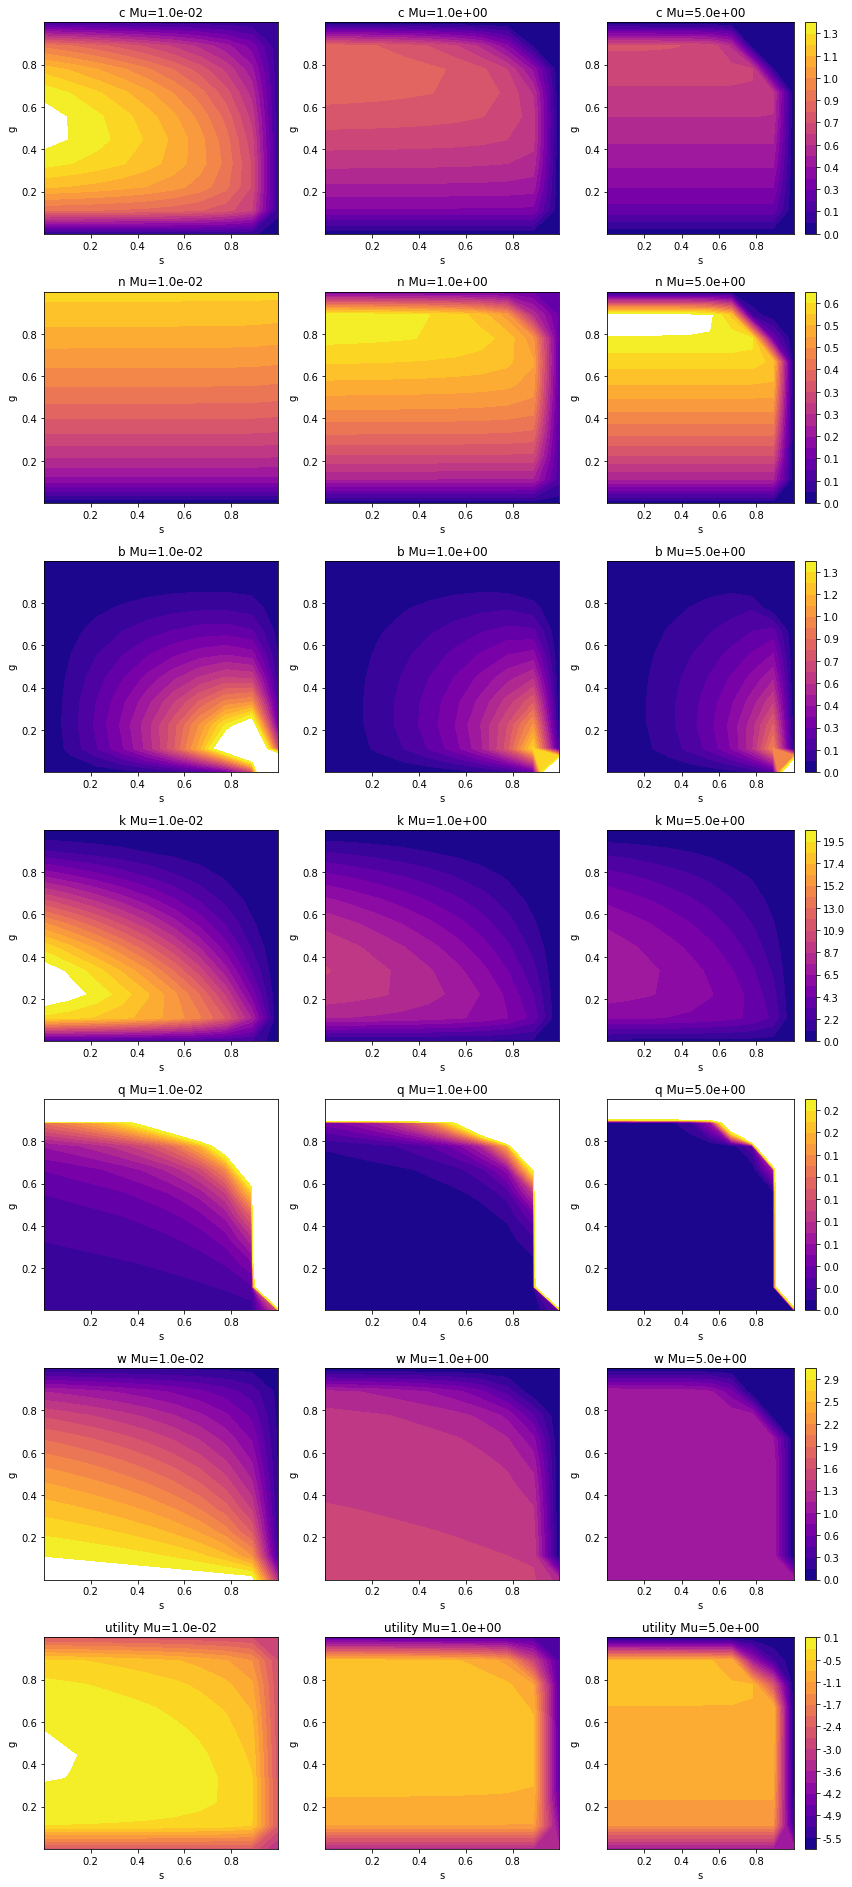

In [93]:
steadystate.plot_steady_state_effects(ss_mu, 'Mu', save='fig_steady_state_effects_rho.pdf')
plt.savefig('fig_heatmap_steady_state.pdf', bbox_inches='tight', format='pdf')

-----
# Analysis of Crises

In [148]:
def inv_log_hist(ax, s, label, col):
    bins = np.logspace(-6,0,100)
    inv = np.histogram(1-s,bins=bins)
    ax.plot(np.log(inv[1][:-1]), np.log(inv[0]),'o', color = col)

def crisis_log_hist(ax, crisis, label, col): 
    cris = np.histogram(crisis, bins=np.logspace(0,2,50))
    ax.plot(np.log(cris[1][:-1]),np.log(cris[0]), 'x', label = r"$\mathcal{S}=$"+"{:.3f}".format(label), color = col)

def double_hist(c_sim):
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10,5)
    
    s0_list = c_sim[list(c_sim.keys())[1]].keys()
    
    for s0 in s0_list:
        col = (np.random.uniform(),np.random.uniform(),np.random.uniform())
        inv_log_hist(ax[0], c_sim['Simulation'][s0].s, s0, col)
        crisis_log_hist(ax[1], c_sim['Crisis'][s0].duration, s0, col)

    ax[0].set_title('Histogram of Investment Proportion')
    ax[0].set_xlabel(r'$\log$ (1-s)')
    ax[0].set_ylabel(r'$\log$ frequency')
    ax[0].legend()
    
    ax[1].set_title('Histogram of Crisis Duration')
    ax[1].set_xlabel(r'$\log$ Duration')
    ax[1].set_ylabel(r'$\log$ frequency')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

-----
# Investment news and economic crises

In [206]:
def crisis_timing(df):
    # Index that is true when there is no crisis
    ix = df.k - df.n > 0
    # Start of a crisis is when capital becomes the limiting factor
    start = np.flatnonzero((ix.shift(-1)==False) & (ix==True))[:, np.newaxis]
    # End of a crisis is when labour becomes the limiting factor
    end   = np.flatnonzero((ix.shift(-1)==True) & (ix==False))[:, np.newaxis]
    # If the last crisis does not 
    if start.shape[0] > end.shape[0]:
        end = np.vstack([end,np.array([ix.shape[0]])])
    df = pd.DataFrame(np.hstack([start, end]), columns=['start','end'])
    df.loc[:,'duration'] = df.end - df.start
    return df

In [237]:
def sim_avg_crisis(s_c_weight_range, news_range):
    # Results setup
    avg_c = pd.DataFrame(index=s_c_weight_range, columns=news_range)
    prop_crisis = pd.DataFrame(index=s_c_weight_range, columns=news_range)
    freq_crisis = pd.DataFrame(index=s_c_weight_range, columns=news_range)
    
    # Run the simulation
    for ns, scw in product(news_range, s_c_weight_range):
        
        # Set parameterts
        params['news_spread'] = ns
        params['s_c_weight'] = scw
        
        # Simulate the economy
        df = model.simulate(p=params, t_end=T, err=death_epsilon)
        
        # Calculate the effects of the consumption
        if df.shape[0] < T:
            # If the economy has died set range to None
            avg_c.loc[scw, ns] = None
        else:
            avg_c.loc[scw, ns] = df.c.mean() #np.log(df.c.max() - df.c.min())
        
        # Calculate the crises in the system (n - k < 0 -> crisis)
        crisis = crisis_timing(df)
        prop_crisis.loc[scw, ns] = crisis.duration.sum() / df.shape[0]
        freq_crisis.loc[scw, ns] = crisis.shape[0]
        
    return avg_c, prop_crisis, freq_crisis

In [238]:
from itertools import product

# Set Variation in s0 and s_c_weight
n_detail = 10
news_range = np.linspace(0.0, 2.0, n_detail)
s_c_weight_range = np.linspace(0.0, 1.0, n_detail)

# Set simulation parameters
params = model.gen_params()
start = model.gen_start()
T = 1e4
death_epsilon = 1e-4 # stops simulation if c, n, or k < err

In [239]:
range_c, prop_crisis, count_crisis = sim_avg_crisis(s_c_weight_range, news_range)

In [233]:
# Generate a contour figure for the results
from matplotlib.ticker import FormatStrFormatter, AutoMinorLocator

def nice_cbar(q, ax):
    cbar = plt.colorbar(q, ax=ax)
    form = FormatStrFormatter('%0.1f')
    cbar.ax.yaxis.set_major_formatter(form)

def double_contour(avg_c, prop_crisis, count_crisis, save='figures/fig_dynamic_sentiment_phases.pdf', cmap='plasma'):
    fig, axs = plt.subplots(nrows = 1, ncols = 3)
    
    X, Y = np.meshgrid(avg_c.T.columns, avg_c.T.index)
    
    axs[0].set_title('Range of Consumption (None if dead)')
    kwargs = dict(levels=20, cmap=cmap)
    q = axs[0].contourf(X, Y, avg_c.T, **kwargs)
    nice_cbar(q, axs[0])
    
    axs[1].set_title('Proportion of Crises (Time in n > k)')
    kwargs = dict(levels=np.linspace(0.0, 1.0, 20), cmap=cmap)
    q = axs[1].contourf(X, Y, prop_crisis.T, **kwargs)
    nice_cbar(q, axs[1])
    
    axs[2].set_title('Number of Crises')
    kwargs = dict(levels=100, cmap=cmap)
    q = axs[2].contourf(X, Y, count_crisis.T.astype(float), **kwargs)
    nice_cbar(q, axs[2])
    
    for ax in axs:
        ax.set_ylabel("Range of News")
        ax.set_xlabel("Weight of C")
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        
    fig.set_size_inches(15,5)
    plt.tight_layout()
    plt.savefig(save, bbox_inches='tight', format='pdf')
    plt.show()

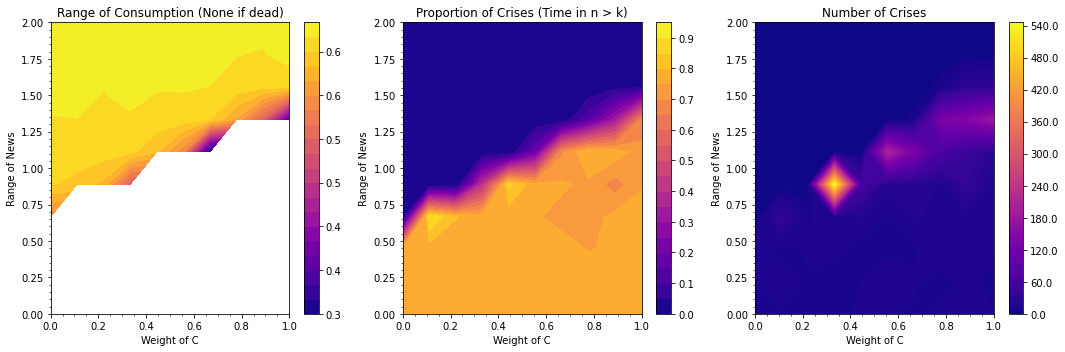

In [240]:
double_contour(range_c, prop_crisis, count_crisis, save='figures/crisis_heatmaps_avg_c.pdf', cmap='plasma')

In [102]:
from itertools import product

# Set Variation in s0 and s_c_weight
n_detail = 20
news_range = np.linspace(0.0,4.0,n_detail)
s_c_weight_range = np.linspace(0.0,1.0,n_detail)

# Set simulation parameters
params = model.gen_params()
start = model.gen_start()
T = 3e4
death_epsilon = 1e-4 # stops simulation if c, n, or k < err

In [103]:
range_c_test, crisis_tests = sim_avg_crisis(s_c_weight_range, news_range)

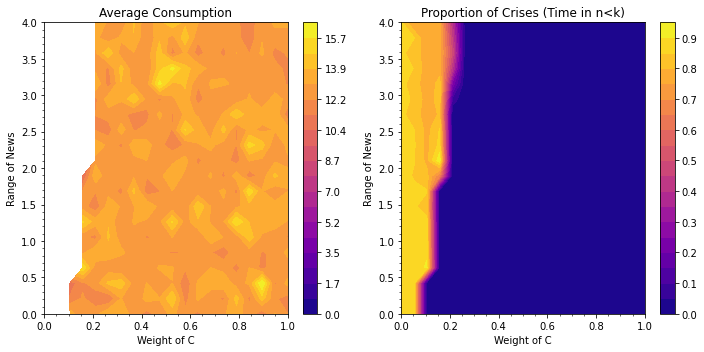

In [104]:
double_contour(range_c_test, crisis_tests, save='figures/test.pdf', cmap='plasma')

In [251]:
def comparison_plot(timeseries, title, p, save):
    ncols = len(list(timeseries.keys()))
    fig, ax = plt.subplots(ncols=ncols, nrows=3)
    
    for i, k in enumerate(timeseries.keys()):
        ax[0, i].hist(timeseries[k].s.iloc[100:-100], bins=20, alpha=0.5, label='s')
        ax[0, i].hist(-k * timeseries[k].news.iloc[100:-100], bins=20, alpha=0.5, label='news')
        ax[0, i].set_title('Weight C = {}'.format(k))
        ax[0, i].legend()
        ax[0, i].set_yscale('log')
        
        ax[1, i].plot(timeseries[k].n.iloc[100:-100], label='n')
        ax[1, i].plot(timeseries[k].k.iloc[100:-100], label='k')
        ax[1, i].legend()
        ax[1, i].set_yscale('log')
        
        ax[2, i].plot(timeseries[k].s.iloc[100:-100], label='s')
        ax[2, i].legend()
        
    fig.suptitle(title)
    fig.set_size_inches(15,6)
    plt.tight_layout()
    plt.savefig(save, bbox_inches='tight', format='pdf')
    plt.show()

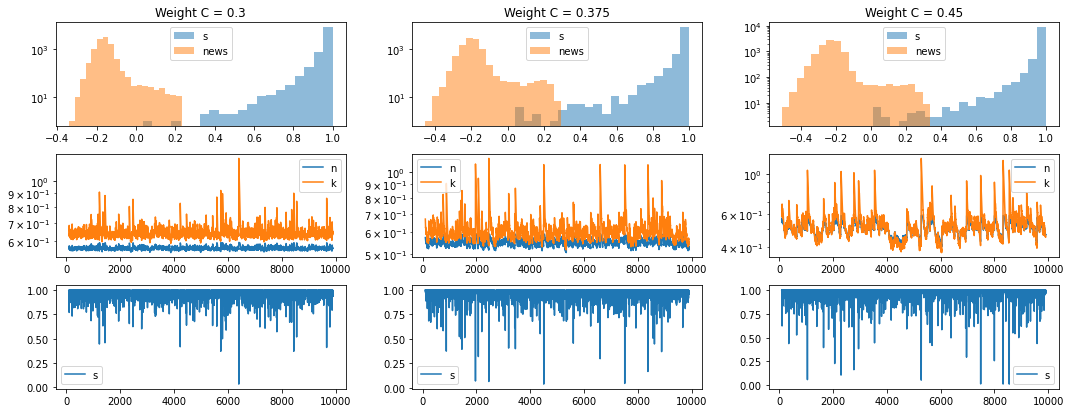

In [252]:
# Set simulation parameters
start = model.gen_start()
params = model.gen_params()
T = 1e4
death_epsilon = 1e-4 # stops simulation if c, n, or k < err

params['news_spread'] = 1.0
params['s_theta'] = 5.0
params['sigmaZ'] = 0.2

test_range = [0.3,0.375,0.45]

# Standard Setup
timeseries = {}
for s_range in test_range:
    params['s_c_weight'] = s_range
    timeseries[s_range] = model.simulate(start, params, t_end=T, err=death_epsilon)
    
title = ''#'Params: s_c_w={:.2f} s_interval={:.2f}'.format(params['s_c_weight'], params['s_interval'])
comparison_plot(timeseries, title, params, save='figures/comparison_plot_timeseries.pdf')

In [267]:
# Set simulation parameters
start = model.gen_start()
params = model.gen_params()
T = 5e4
death_epsilon = 1e-4 # stops simulation if c, n, or k < err

params['news_spread'] = 1.0
params['s_theta'] = 5.0
params['sigmaZ'] = 0.2

test_range = [0.1, 0.5, 0.7, 0.9]

# Standard Setup
timeseries_logHist = {}
for s_range in test_range:
    params['s_c_weight'] = s_range
    timeseries_logHist[s_range] = model.simulate(start, params, t_end=T, err=death_epsilon)

<ipython-input-275-fcb4b635c540>:6: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(inv[1][:-1]), np.log(inv[0]),'o', color = col, label=label)
<ipython-input-275-fcb4b635c540>:6: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(inv[1][:-1]), np.log(inv[0]),'o', color = col, label=label)
<ipython-input-275-fcb4b635c540>:6: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(inv[1][:-1]), np.log(inv[0]),'o', color = col, label=label)
<ipython-input-275-fcb4b635c540>:6: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(inv[1][:-1]), np.log(inv[0]),'o', color = col, label=label)


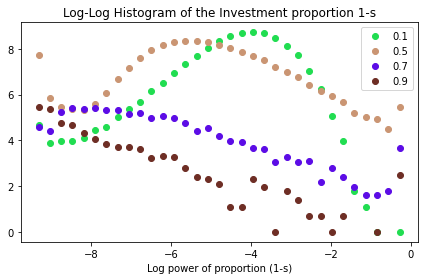

In [275]:
def inv_log_hist(ax, s, label):
    bins = np.logspace(-6,0,50)
    #x = np.linspace(-10, 1 , 100)
    inv = np.histogram(1-s,bins=bins)
    #m, q = np.polyfit(np.log(inv[1][71:]),np.log(inv[0][70:]), deg=1)
    ax.plot(np.log(inv[1][:-1]), np.log(inv[0]),'o', color = col, label=label)
    #ax.plot(x , x*m+q,'--', color = col , label = r'fit = ' + str(np.round(m,2)))

fig, ax = plt.subplots(1,1)
for i,k in enumerate(timeseries_logHist.keys()):
    col = (np.random.uniform(),np.random.uniform(),np.random.uniform())
    inv_log_hist(ax, timeseries_logHist[k].s, k)
ax.legend()
ax.set_title('Log-Log Histogram of the Investment proportion 1-s')
ax.set_xlabel('Log power of proportion (1-s)')
plt.tight_layout()
plt.savefig('figures/log_hist_s.pdf', bbox_inches='tight', format='pdf')

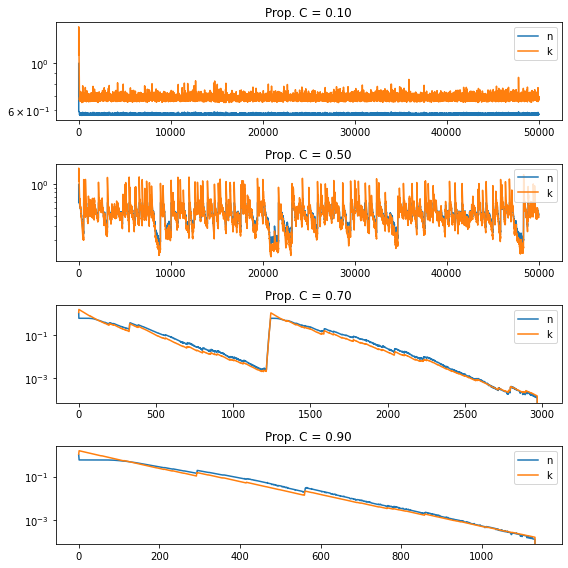

In [280]:
fig, ax = plt.subplots(ncols=1, nrows=len(list(timeseries_logHist.keys())))
for i,k in enumerate(timeseries_logHist.keys()):
    col = (np.random.uniform(),np.random.uniform(),np.random.uniform())
    ax[i].plot(timeseries_logHist[k].n, label='n')
    ax[i].plot(timeseries_logHist[k].k, label='k')
    ax[i].set_yscale('log')
    ax[i].legend()
    ax[i].set_title('Prop. C = {:.2f}'.format(k))

fig.set_size_inches(8,8)
plt.tight_layout()
plt.savefig('figures/fig_timeseries_n_k.pdf', bbox_inches='tight', format='pdf')

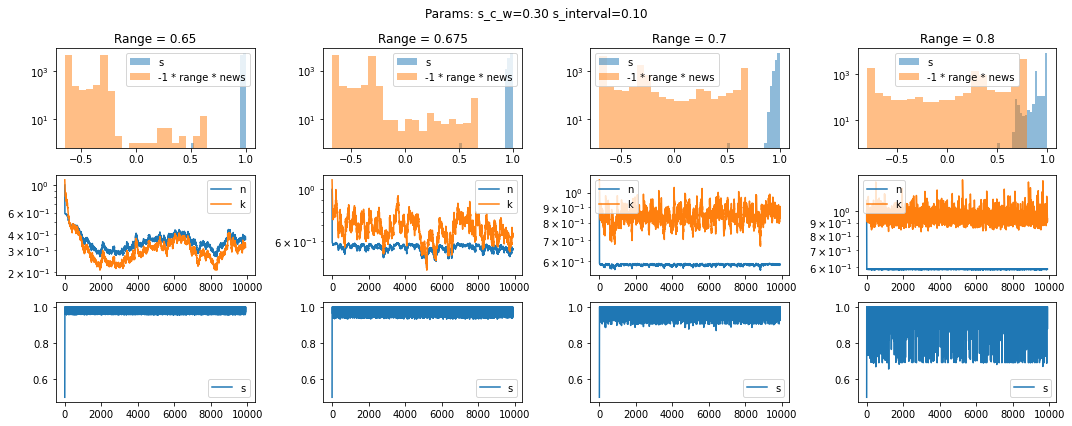

In [73]:
test_range = [0.65, 0.675, 0.7, 0.8]

# Set simulation parameters
start = model.gen_start()
params = model.gen_params()
T = 1e4
death_epsilon = 1e-4 # stops simulation if c, n, or k < err

#params['s_max'] = 1-1e-2
params['sigmaZ'] = 0.6

# Standard Setup
timeseries = {}
for s_range in test_range:
    params['news_spread'] = s_range
    timeseries[s_range] = model.simulate(start, params, t_end=T, err=death_epsilon)
    
title = 'Params: s_c_w={:.2f} s_interval={:.2f}'.format(params['s_c_weight'], params['s_interval'])
comparison_plot(timeseries, title)

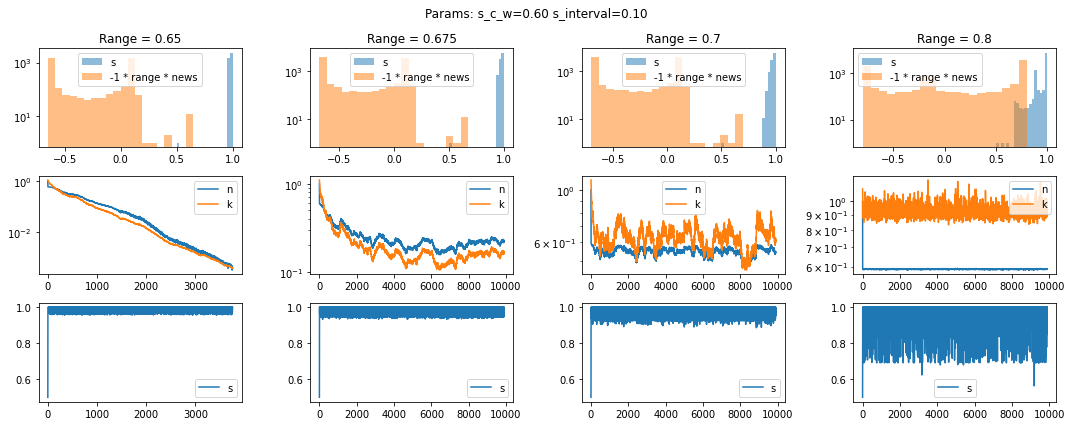

In [70]:
test_range = [0.65, 0.675, 0.7, 0.8]

# Set simulation parameters
start = model.gen_start()
params = model.gen_params()
T = 1e4
death_epsilon = 1e-4 # stops simulation if c, n, or k < err

# Increasing the weight of consumption
params['s_c_weight'] = 0.6

timeseries = {}
for s_range in test_range:
    params['news_spread'] = s_range
    timeseries[s_range] = model.simulate(start, params, t_end=T, err=death_epsilon)
    
title = 'Params: s_c_w={:.2f} s_interval={:.2f}'.format(params['s_c_weight'], params['s_interval'])
comparison_plot(timeseries, title)

Test #1 -> Confirming the fact that a change in weight on consumption in the news doesn't change the outcomes markedly
Result: The distribution of news becomes more uniform BUT the location of the two news limits is problematic
We observe that between 0.7 and 0.8 the second peak in the news dramatically (more negative news) otherwise the news itself is essentially always a minor thing.
Why do we observe a shift at range 0.7???????????????

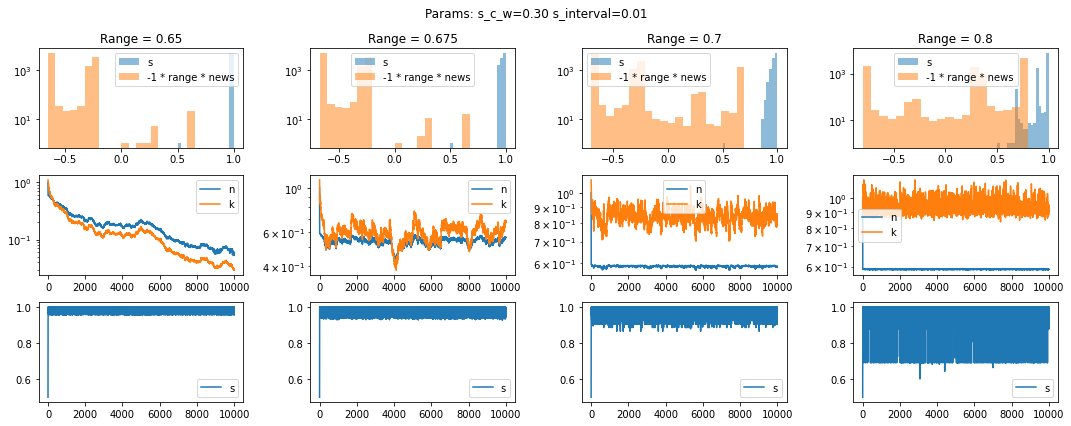

In [64]:
test_range = [0.65, 0.675, 0.7, 0.8]

# Set simulation parameters
start = model.gen_start()
params = model.gen_params()
T = 1e4
death_epsilon = 1e-4 # stops simulation if c, n, or k < err

# Increasing the weight of consumption
params['s_interval'] = 0.01

timeseries = {}
for s_range in test_range:
    params['news_spread'] = s_range
    timeseries[s_range] = model.simulate(start, params, t_end=T, err=death_epsilon)
    
title = 'Params: s_c_w={:.2f} s_interval={:.2f}'.format(params['s_c_weight'], params['s_interval'])
comparison_plot(timeseries, title)

Test #2 -> what happens when the info signals become essentially binary?
Result: The crisis interplay spot shifts the transition downward

-----
# Step function experimentation

----
## Interactive Analysis

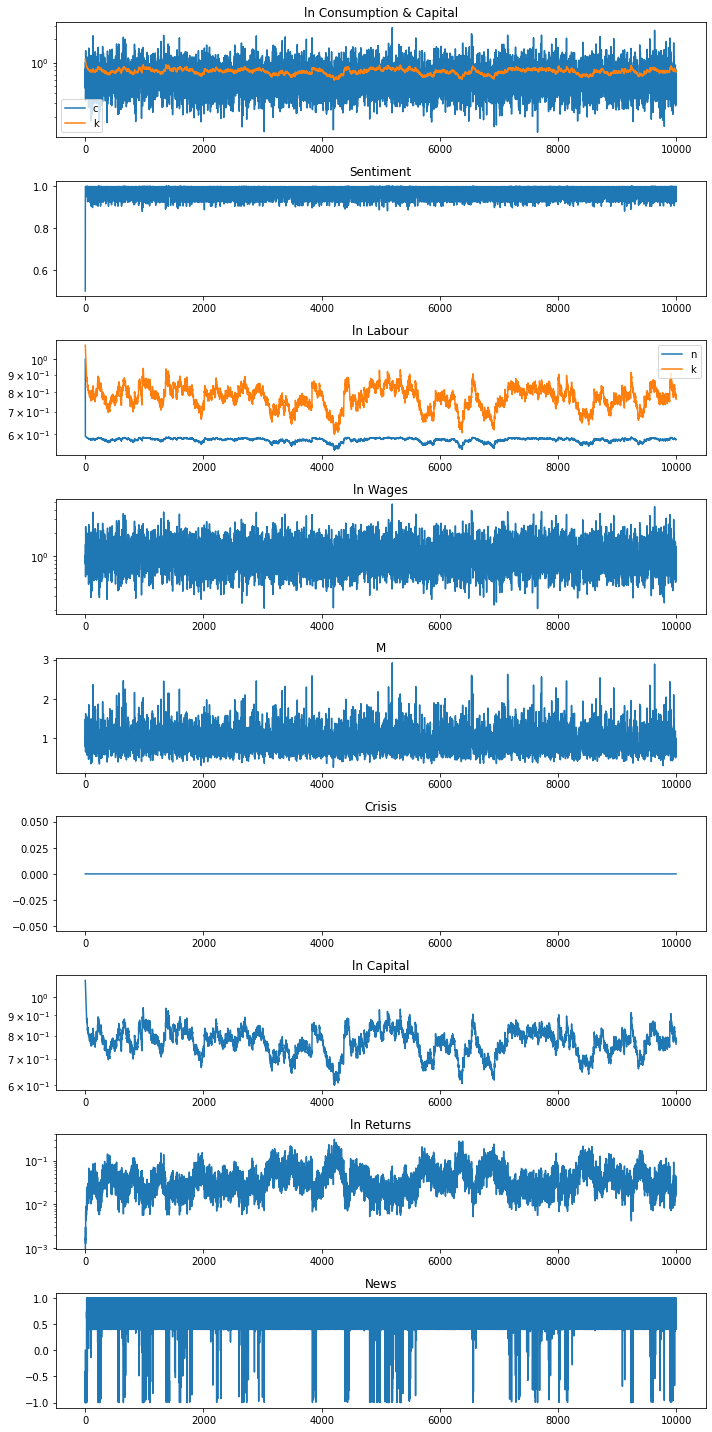

<Figure size 432x288 with 0 Axes>

In [138]:
# Set simulation parameters
params = model.gen_params(s_c_weight=0.3)
start = model.gen_start()

T = 10000
death_epsilon = 1e-4 # stops simulation if c, n, or k < err
np.random.seed(40)
view = (0,T)

df = model.simulate(start, params, t_end=T)

df.loc[:, 'crisis'] = 0.5 * (1.0 + np.sign(df.n - df.k))
df.loc[:, 'inv'] = 100 * (1-df.loc[:,'g'])
df.loc[:,'bc'] = df.b / df.c
df.loc[:,'utility'] = np.log(df.c) - params['gamma'] * (df.n ** 2)

df = df.iloc[view[0]:view[1],:]

plots = {
        'ln Consumption & Capital' : [df.loc[:,['c','k']], True],
        'Sentiment' : [df.s, False],
        'ln Labour' : [df.loc[:,['n','k']], True],
        'ln Wages' : [df.w, True],
        'M' : [df.income, False],
        'Crisis' : [df.crisis, False],
        'ln Capital' : [df.loc[:,['k']], True],
        'ln Returns' : [df.q, True],
        'News' : [df.news, False],
    }


axs = graphs.simulation_graph(plots, size = (10, 20), save='test.pdf')
axs['ln Returns'].axhline(params['interest'])
plt.show()

In [126]:
def step(t: float, x: np.ndarray, p: dict, err:float):
    """Iteration of one step in the simulation
    
    Parameters
    ----------
    t : float
        Current timestep t
    x : np.ndarray
        state variables z, c, n, b, w, k, q, g, s, news, inc, xiz, xin
    p : dict
        Parameters from simulation
        
    Returns
    -------
    bound : float
        Upper bound on consumption
    """
    # Starting variables
    z_, c_, n_, b_, w_, k_, q_, g_, s_, news_, m_, xiz_, k__= x
        
    # Random technology process
    rand = np.random.normal(0, p['sigmaZ'])
    xiz = p['etaZ'] * xiz_ + np.sqrt(1 - p['etaZ'] ** 2) * rand
    z = p['zbar'] * np.exp(xiz)
    
    # Observe "State of economy"
    g = g_
    signal = np.tanh(p['s_theta'] * (s_ - news_))
    s = 0.5 * ((p['s_max'] - p['s_min']) * signal + p['s_max'] + p['s_min'])

    # Determine Consumption
    c = model.bisection(z, g, k_, p)
    
    # Working hours via market clearing
    n = ((c / z) ** (-1 * p['mu']) - p['alpha'] * k_ ** (-1 * p['mu']))
    n = (n / (1 - p['alpha'])) ** (-1 / p['mu'])
    
    # Firm observes desired working hours, sets the wage accordingly
    rho = -1 * p['mu']
    temp = (p['alpha'] * k_ ** rho + (1 - p['alpha']) * n ** rho) 
    temp = temp ** ((1 / rho) - 1)
    w = (1 - p['alpha']) * z * temp * (n ** (rho - 1))
    
    c_alt = z * (p['alpha'] * k_ ** rho + (1 - p['alpha']) * n ** rho) ** (1 / rho)
    
    # Income
    income = w * n + (b_  + q_ * k__) / (1 + p['inflation'])
    m = g * income - c 
    #print("M: ", m)
    
    # Investment & Bonds
    investment = income * (1 - g)
    b = (1 + p['interest']) * s * investment
    
    # Capital & Risky return
    k = (1 - p['depreciation']) * k_ + (investment * (1 - s))
    temp = (p['alpha'] * k ** rho + (1 - p['alpha']) * n ** rho) 
    temp = temp ** ((1 / rho) - 1)
    q = p['alpha'] * z * temp * k ** (rho - 1)
    
    # Signals to the household investor
    th_c = (0.1*c_)**(-1)
    th_r = (0.1*p['interest'])**(-1)
    info_c = p['sentiment'] * np.tanh(th_c*(c - c_))
    #info_r = (q - p['interest']) / (q + p['interest'])
    info_r = p['sentiment'] * np.tanh(th_r*(q - p['interest']))
    #print(info_c, ' ' , info_r)
    news = p['s0'] * info_c + (1 - p['s0']) * info_r
    
    return z, c, n, b, w, k, q, g, s, news, m, xiz, k_

# TO CHANGE THE STEP DO NOT CHANGE THE RETURN VARIABLES

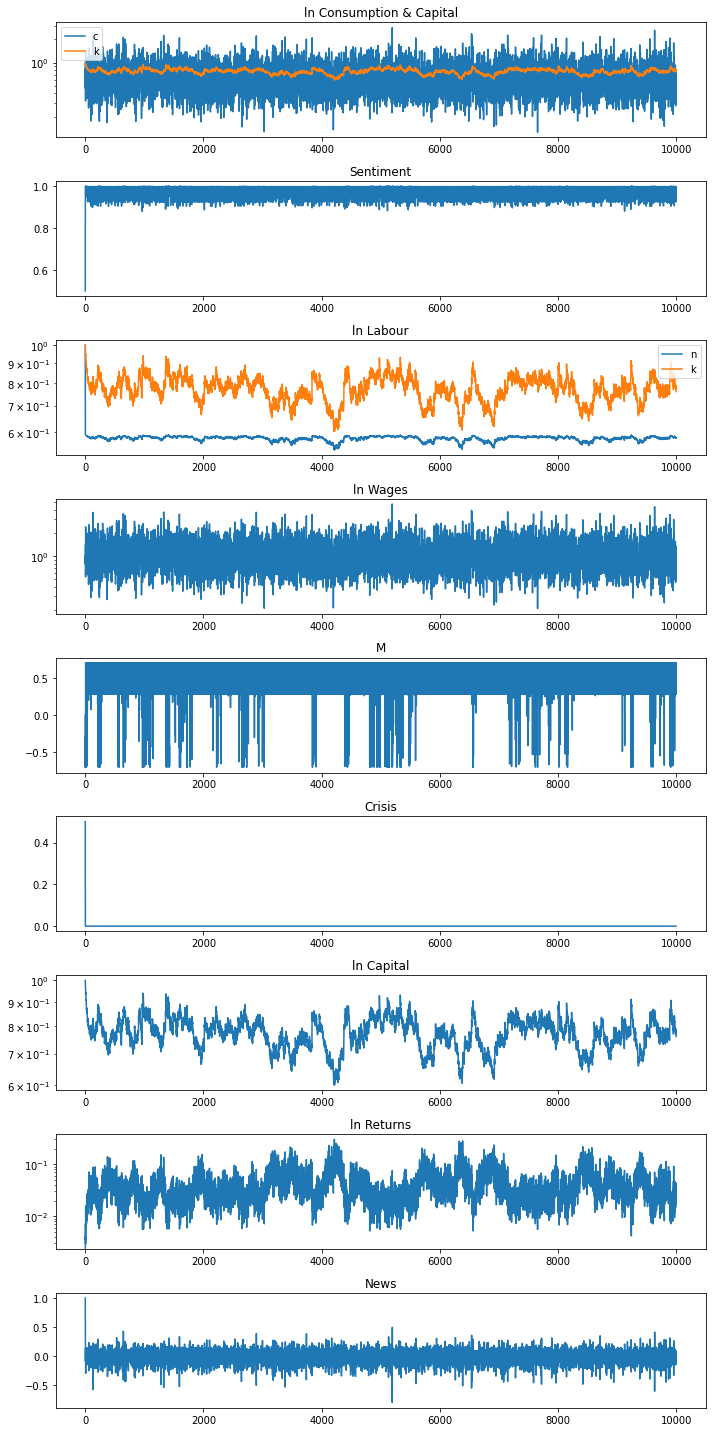

<Figure size 432x288 with 0 Axes>

In [131]:
params = {'etaZ': 0.2, 'sigmaZ': 0.4, 'zbar': 1.0,
          'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.01, 
          's_min': 1e-4, 's_max': 1-1e-4,'s_theta':5, 's0':0.3, 'sentiment':.7,
          'gamma': 1.0, 'alpha': 0.33, 'mu': 8.32}

start = dict(z=1, c=1, n=1, b=1, w=1, k=1, q=0.0, g=0.7, s=0.5, m=0, news=1, k_=0, xin=1)

T = 10000
np.random.seed(40)
view = (0,T)

df = model.simulate(start, params, step_func=step, t_end=T)

df.loc[:, 'crisis'] = 0.5 * (1.0 + np.sign(df.n - df.k))
df.loc[:, 'inv'] = 100 * (1-df.loc[:,'g'])
df.loc[:,'bc'] = df.b / df.c
df.loc[:,'utility'] = np.log(df.c) - params['gamma'] * (df.n ** 2)

df = df.iloc[view[0]:view[1],:]

plots = {
        'ln Consumption & Capital' : [df.loc[:,['c','k']], True],
        'Sentiment' : [df.s, False],
        'ln Labour' : [df.loc[:,['n','k']], True],
        'ln Wages' : [df.w, True],
        'M' : [df.m, False],
        'Crisis' : [df.crisis, False],
        'ln Capital' : [df.loc[:,['k']], True],
        'ln Returns' : [df.q, True],
        'News' : [df.news, False],
    }


axs = graphs.simulation_graph(plots, size = (10, 20), save='test.pdf')
axs['ln Returns'].axhline(params['interest'])
plt.show()

In [77]:
len(axs)

9

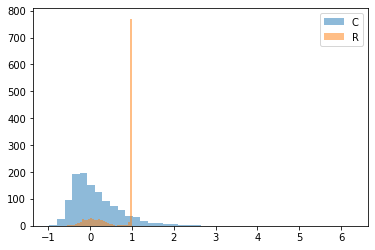

In [78]:
fig, ax = plt.subplots(1,1)
info_c = df.c.iloc[1:] / df.c.shift(-1) - 1
info_r = (df.q - params['interest']) / (df.q + params['interest'])
bins = 40
#ax.hist(df.news, bins = bins, label='N', alpha=0.5, color='black')
ax.hist(info_c, bins = bins, label='C', alpha=0.5)
ax.hist(info_r, bins = bins, label='R', alpha=0.5)
#ax.set_yscale('log')
ax.legend()
plt.show()


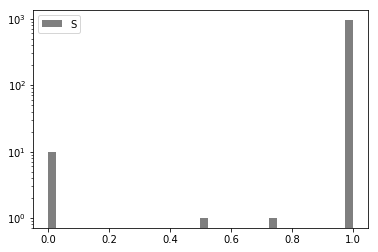

In [349]:
fig, ax = plt.subplots(1,1)
info_c = df.c.iloc[1:] / df.c.shift(-1) - 1
info_r = (df.q - params['interest']) / (df.q + params['interest'])
bins = 40
ax.hist(df.s, bins=40, label='S', alpha=0.5, color='black')
#ax.hist(df.news, bins = bins, label='N', alpha=0.5)
ax.set_yscale('log')
ax.legend()
plt.show()


(-1.05, 1.05)

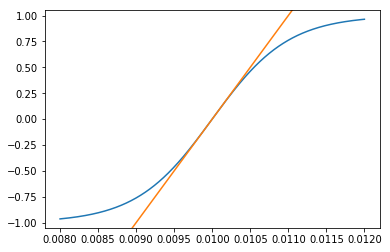

In [257]:
x = np.linspace(0.008,0.012,100000)
def f(x,r):
    th = (r*(0.1))**(-1)
    return np.tanh(th*(x-r)), th
plt.plot(x,f(x,0.01)[0])
plt.plot(x,(x-0.01)*f(x,0.01)[1])
plt.ylim([-1.05,1.05])
#plt.plot(np.ones(10)*0.01, np.linspace(-1,1,10))